# Comparing 3D CNN, and Vision Transformer feature extractors for Isolated Sign Language Recognition

In [1]:
import torch
import test
import configs
from torchvision.transforms import v2
from video_dataset import VideoDataset
from pathlib import Path
from torch.utils.data import DataLoader
from models import pytorch_mvit, pytorch_r3d, pytorch_s3d, pytorch_swin3d
import json
import utils
import torch
import gc
import torch.nn.functional as F
import numpy as np
import random

def set_seed(seed=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  
set_seed()

with open('wlasl_implemented_info.json', 'r') as f:
  imp_info = json.load(f)


In [2]:
print(imp_info['splits'])
print(imp_info['models'].keys())
model_info = imp_info['models']

['asl100', 'asl300']
dict_keys(['MViT_V1_B', 'MViT_V2_S', 'Swin3D_B', 'Swin3D_S', 'Swin3D_T', 'Resnet2D_1D_18', 'Resnet3D_18', 'S3D'])


In [3]:
split = 'asl100'
root = Path('../data/WLASL/WLASL2000')
labels = Path(f'./preprocessed/labels/{split}')

## Resnet3D_18


In [4]:
exp_no = '004' #chosen based on wandb dashboard
model = 'Resnet3D_18'
config_path = Path(f'configfiles/{split}/{model}_{exp_no}.ini')
output = Path(f'runs/{split}/{model}_exp{exp_no}')
save_path = output / 'checkpoints'
arg_dict = {
  'model' : model,
  'exp_no': exp_no,
  'split' : split,
  'root' : root,
  'labels' : labels,
  'save_path' : save_path,
  'config_path' : config_path 
}


In [5]:
config = configs.load_config({'config_path':config_path})
configs.print_config(config)

TRAINING:
    batch_size            : 2
    update_per_step       : 4
    max_epoch             : 200
    early_stopping        : {'metric': ('val', 'loss'), 'mode': 'min', 'patience': 50, 'min_delta': 0.01}
    batch_size_equivalent : 8

OPTIMIZER:
    eps                     : 0.001
    backbone_init_lr        : 1e-05
    backbone_weight_decay   : 0.0001
    classifier_init_lr      : 0.001
    classifier_weight_decay : 1e-07

MODEL_PARAMS:
    drop_p : 0.5

SCHEDULER:
    tmax    : 100
    eta_min : 1e-05

DATA:
    num_frames : 32
    frame_size : 224

ADMIN:
    config_path : configfiles/asl100/Resnet3D_18_004.ini



### Setup data

In [6]:
resnet_info = model_info[model]
utils.print_dict(resnet_info)
mean = resnet_info['mean']
std = resnet_info['std']

r3d18_final = v2.Compose([
  v2.Lambda(lambda x: x.float() / 255.0),
  v2.Normalize(mean=mean, std=std),
  v2.Lambda(lambda x: x.permute(1,0,2,3)) 
])

# train_transforms = v2.Compose([v2.RandomCrop(config['data']['frame_size']),
#                                  v2.RandomHorizontalFlip(),
#                                  r3d18_final])
test_transforms = v2.Compose([v2.CenterCrop(config['data']['frame_size']),
                                r3d18_final])

test_instances = labels / 'test_instances_fixed_frange_bboxes_len.json'
val_instances = labels / 'val_instances_fixed_frange_bboxes_len.json'
test_classes = labels / 'test_classes_fixed_frange_bboxes_len.json'
val_classes = labels / 'val_classes_fixed_frange_bboxes_len.json'

test_set = VideoDataset(root, test_instances, test_classes,
    transforms=test_transforms, num_frames=config['data']['num_frames'])
val_set = VideoDataset(root, val_instances, val_classes,
    transforms=test_transforms, num_frames=config['data']['num_frames'])

test_loader = DataLoader(test_set,
    batch_size=1, shuffle=True, num_workers=2,pin_memory=False, drop_last=False)
val_loader = DataLoader(val_set,
    batch_size=1, shuffle=True, num_workers=2,pin_memory=False, drop_last=False)




num_classes = len(set(test_set.classes))
print(len(test_set))
# print(len(test_loader))
print(num_classes)
# print(len(set(test_loader.dataset.classes)))


{
idx : 6
mean : [0.43216, 0.394666, 0.37645]
std : [0.22803, 0.22145, 0.216989]
}

258
100


### Setup model

In [7]:
#unfortunately, i believe the best weights may not have saved correctly
#using the last available weights
checkpoint_path = [x for x in save_path.iterdir() if x.name.endswith('.pth')]
print(checkpoint_path)

[PosixPath('runs/asl100/Resnet3D_18_exp004/checkpoints/checkpoint_117.pth')]


In [8]:
checkpoint = torch.load(checkpoint_path[0])
r3d18 = pytorch_r3d.Resnet3D_18_basic(num_classes=num_classes)
r3d18.load_state_dict(checkpoint['model_state_dict'])

/tmp/ipykernel_2251792/2323645054.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path[0])


<All keys matched successfully>

### Test it

In [11]:
test.test_top_k(
  model=r3d18,
  test_loader=val_loader,
  save_dir = save_path,
  name='val-top-k.txt'
)

test.test_top_k(
  model=r3d18,
  test_loader=test_loader,
  save_dir = save_path,
  name='test-top-k.txt'
)

Testing: 100%|██████████| 338/338 [00:29<00:00, 11.43it/s]


top-k average per class acc: 0.6285, 0.8563333333333333, 0.9041666666666667
Overall top1 (sklearn style) 0.6242603550295858


Testing: 100%|██████████| 258/258 [00:22<00:00, 11.40it/s]

top-k average per class acc: 0.5526666666666666, 0.8438333333333332, 0.8991666666666666
Overall top1 (sklearn style) 0.5542635658914729


### Plot results

In [14]:
accuracy, class_report, all_preds, all_targets = test.test_model(r3d18, test_loader)
print(f'Accuracy score: {accuracy}')

Testing: 100%|██████████| 258/258 [00:22<00:00, 11.42it/s]

Accuracy score: 0.5542635658914729


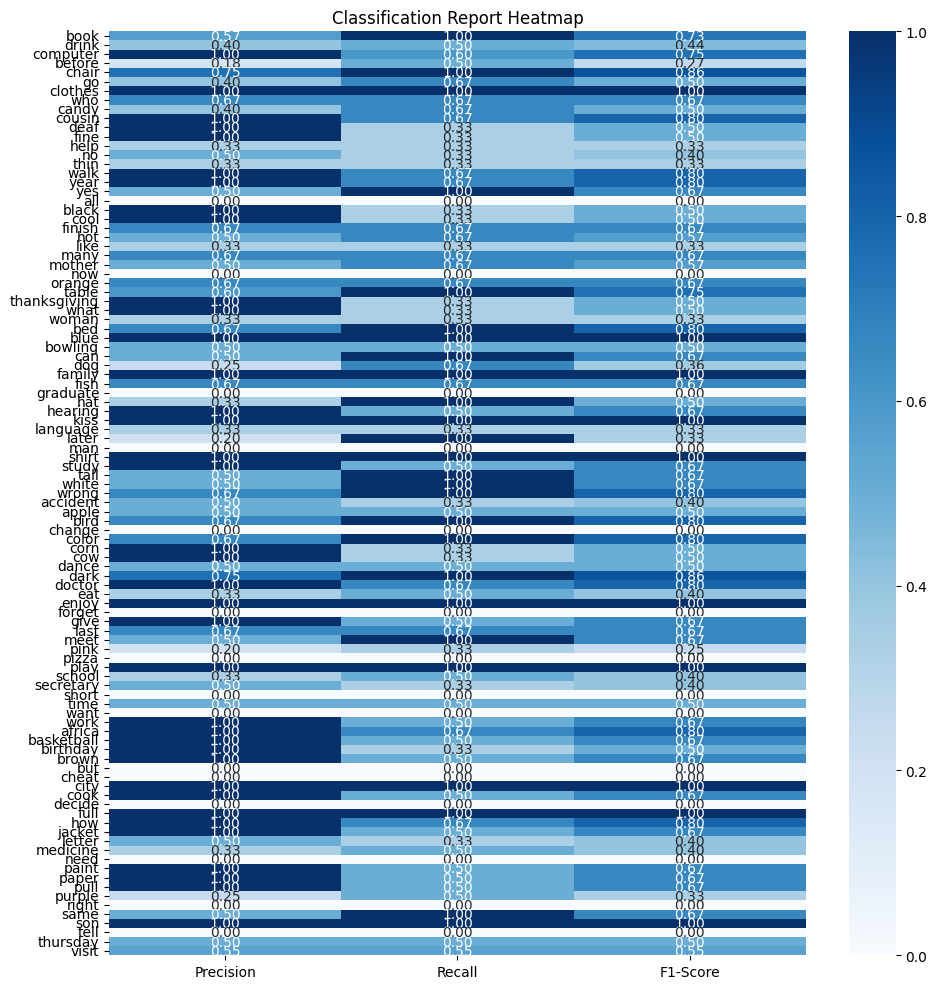

In [ ]:
classes_path = './wlasl_class_list.json'
test.plot_heatmap(report=class_report,
                  classes_path=classes_path,
                  title='Test set Classification',
                  save_path=output)

### Resnet2D_1D_18


In [ ]:
exp_no = '001' #chosen based on wandb dashboard
model = 'Resnet2D_1D_18'
config_path = Path(f'configfiles/{split}/{model}_{exp_no}.ini')
output = Path(f'runs/{split}/{model}_exp{exp_no}')
save_path = output / 'checkpoints'
arg_dict = {
  'model' : model,
  'exp_no': exp_no,
  'split' : split,
  'root' : root,
  'labels' : labels,
  'save_path' : save_path,
  'config_path' : config_path 
}


In [ ]:
config = configs.load_config({'config_path':config_path})
configs.print_config(config)